In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
import seaborn as sns

For this case study we will be examining if crimes are committed at a higher rate in the Fenway area on days the Red Sox play home games. The crimes we examine will fall into 4 categories: Assault, Public Indecency, Vandalism, and Operating Under the Influence. Furthermore, we'll define the "Fenway Area" as district D4 on the following [map](https://www.masslive.com/resizer/U129cXoH18JOJlIf8NMFTDfVp3M=/1280x0/smart/advancelocal-adapter-image-uploads.s3.amazonaws.com/image.masslive.com/home/mass-media/width2048/img/mass_river_boston_news/photo/boston-police-districts-map-b04e492a0e947a1d.jpg).

To start with, we'll import crime report data from boston.gov. We have records from 06/15/2015 to the present day, and so those dates will be the focus of this analysis.

In [2]:
# import crime data
PATH = 'https://data.boston.gov/dataset/6220d948-eae2-4e4b-8723-2dc8e67722a3/resource/12cb3883-56f5-47de-afa5-3b1cf61b257b/download/tmpve8waaev.csv'
crimes = pd.read_csv(PATH, low_memory=False)
crimes.info()
crimes.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462524 entries, 0 to 462523
Data columns (total 17 columns):
INCIDENT_NUMBER        462524 non-null object
OFFENSE_CODE           462524 non-null int64
OFFENSE_CODE_GROUP     426839 non-null object
OFFENSE_DESCRIPTION    462524 non-null object
DISTRICT               460186 non-null object
REPORTING_AREA         462524 non-null object
SHOOTING               37431 non-null object
OCCURRED_ON_DATE       462524 non-null object
YEAR                   462524 non-null int64
MONTH                  462524 non-null int64
DAY_OF_WEEK            462524 non-null object
HOUR                   462524 non-null int64
UCR_PART               426729 non-null object
STREET                 446665 non-null object
Lat                    434632 non-null float64
Long                   434632 non-null float64
Location               462524 non-null object
dtypes: float64(2), int64(4), object(11)
memory usage: 60.0+ MB


,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,TESTTEST2,423,NaN,ASSAULT - AGGRAVATED,External,,0,2019-10-16 00:00:00,2019,10,Wednesday,0,NaN,RIVERVIEW DR,NaN,NaN,"(0.00000000, 0.00000000)"
1,I92102201,3301,NaN,VERBAL DISPUTE,E13,583,0,2019-12-20 03:08:00,2019,12,Friday,3,NaN,DAY ST,42.325122,-71.107779,"(42.32512200, -71.10777900)"
2,I92097173,3115,NaN,INVESTIGATE PERSON,C11,355,0,2019-10-23 00:00:00,2019,10,Wednesday,0,NaN,GIBSON ST,42.297555,-71.059709,"(42.29755500, -71.05970900)"
3,I92094519,3126,NaN,WARRANT ARREST - OUTSIDE OF BOSTON WARRANT,D14,765,0,2019-11-22 07:50:00,2019,11,Friday,7,NaN,BROOKS ST,42.355120,-71.162678,"(42.35512000, -71.16267800)"
4,I92089785,3005,NaN,SICK ASSIST,E13,574,0,2019-11-05 18:00:00,2019,11,Tuesday,18,NaN,WASHINGTON ST,42.309718,-71.104294,"(42.30971800, -71.10429400)"


There are a little over 460,000 crimes records. Since our column names are in caps, we'll start by converting those to lower case. Additionally, the OCCURRED_ON_DATE field is a timestamp. Since we only care about the date, we'll convert accordingly as well. Afterwards, we can filter down to our district of interest.

In [0]:
# convert column names to lower case
crimes.columns = crimes.columns.str.lower()
# convert date column
crimes['occurred_on_date'] = pd.DatetimeIndex(crimes['occurred_on_date']).date
# filter out crimes reports outside Fenway area (District D4)
crimes_fenway = crimes[crimes.district == 'D4']

In [0]:
# define descriptions that fall into each relevant category
assault_descriptions = ['ASSAULT - AGGRAVATED',
                        'ASSAULT SIMPLE - BATTERY',
                        'ASSAULT - SIMPLE',
                        'ASSAULT - AGGRAVATED - BATTERY',
                        'ASSAULT & BATTERY D/W - OTHER',
                        'A&B ON POLICE OFFICER',
                        'ASSAULT & BATTERY D/W - OTHER ON POLICE OFFICER',
                        'ASSAULT D/W - OTHER',
                        'ASSAULT & BATTERY',
                        'ASSAULT D/W - KNIFE ON POLICE OFFICER',
                        'ASSAULT & BATTERY D/W - KNIFE']

publicindecency_descriptions = ['LIQUOR - DRINKING IN PUBLIC',
                                'LIQUOR LAW VIOLATION',
                                'DRUNKENNESS',
                                'LIQUOR/ALCOHOL - DRINKING IN PUBLIC',
                                'DISORDERLY CONDUCT',
                                'DISTURBING THE PEACE/ DISORDERLY CONDUCT/ GATHERING CAUSING ANNOYANCE/ NOISY PAR',
                                'VERBAL DISPUTE',
                                'DISTURBING THE PEACE']

vandalism_descriptions = ['GRAFFITI',
                          'VANDALISM']

oui_descriptions = ['OPERATING UNDER THE INFLUENCE ALCOHOL',
                    'OPERATING UNDER THE INFLUENCE DRUGS',
                    'OPERATING UNDER THE INFLUENCE (OUI) ALCOHOL',
                    'OPERATING UNDER THE INFLUENCE (OUI) DRUGS']

Now that we have defined which crime descriptions fall into our four categories of interest, we can obtain our daily counts for each type. We define a function to do this for us. Additionally, the function will tell us how many crime records there are of each type so we know our overall sample size. Additionally, the function creates 0's for every date with no incidents, otherwise those would be excluded from our analysis.

In [0]:
def get_crime_counts(df, descriptions):
  crimes_oftype = df[df['offense_description'].isin(descriptions)]
  
  # print the number of crimes in this category
  print('There are {} crimes with descriptions matching {}.'.format(len(crimes_oftype), descriptions))
  
  # get incident count for each date with at least one crime
  crime_counts = crimes_oftype.groupby('occurred_on_date').size()
  
  # fill in missing dates with 0's
  idx = pd.date_range('2015-06-15', '2020-02-14')
  crime_counts = crime_counts.reindex(idx, fill_value=0)
  
  return crime_counts

In [6]:
assault_counts = get_crime_counts(crimes_fenway, assault_descriptions)
publicindecency_counts = get_crime_counts(crimes_fenway, publicindecency_descriptions)
vandalism_counts = get_crime_counts(crimes_fenway, vandalism_descriptions)
oui_counts = get_crime_counts(crimes_fenway, oui_descriptions)

There are 4492 crimes with descriptions matching ['ASSAULT - AGGRAVATED', 'ASSAULT SIMPLE - BATTERY', 'ASSAULT - SIMPLE', 'ASSAULT - AGGRAVATED - BATTERY', 'ASSAULT & BATTERY D/W - OTHER', 'A&B ON POLICE OFFICER', 'ASSAULT & BATTERY D/W - OTHER ON POLICE OFFICER', 'ASSAULT D/W - OTHER', 'ASSAULT & BATTERY', 'ASSAULT D/W - KNIFE ON POLICE OFFICER', 'ASSAULT & BATTERY D/W - KNIFE'].
There are 1741 crimes with descriptions matching ['LIQUOR - DRINKING IN PUBLIC', 'LIQUOR LAW VIOLATION', 'DRUNKENNESS', 'LIQUOR/ALCOHOL - DRINKING IN PUBLIC', 'DISORDERLY CONDUCT', 'DISTURBING THE PEACE/ DISORDERLY CONDUCT/ GATHERING CAUSING ANNOYANCE/ NOISY PAR', 'VERBAL DISPUTE', 'DISTURBING THE PEACE'].
There are 2470 crimes with descriptions matching ['GRAFFITI', 'VANDALISM'].
There are 83 crimes with descriptions matching ['OPERATING UNDER THE INFLUENCE ALCOHOL', 'OPERATING UNDER THE INFLUENCE DRUGS', 'OPERATING UNDER THE INFLUENCE (OUI) ALCOHOL', 'OPERATING UNDER THE INFLUENCE (OUI) DRUGS'].


We have 4,492 assault incidents, 1,741 public indecency incidents, and 2,470 vandalism incidents that occurred in the Fenway area, all of which make for sufficiently large sample sizes. However, since there are only 83 records of operating under the influence, I've chosen not to move forward with the analysis of this category.

Now that individual counts have been achieved for every date for which we have records, we need to determine which dates featured a Red Sox home game. For this, we'll use MLB game log information from retrosheet.org. Game data is imported for each of the 5 seasons from 2015 to 2019, and then merged together into a single dataframe. Afterwards, the date field is formatted to match our crime records.

In [7]:
baseball_dfs = []
for i in range(15,20):
  PATH = 'https://github.com/ADEnnaco/datasets/blob/master/GL20{}.TXT?raw=true'.format(i)
  baseball_dfs.append(pd.read_csv(PATH, header=None))
baseball_dfs.append(pd.read_csv('https://github.com/ADEnnaco/datasets/raw/master/GLWC.TXT', header=None))
baseball_dfs.append(pd.read_csv('https://github.com/ADEnnaco/datasets/raw/master/GLDV.TXT', header=None))
baseball_dfs.append(pd.read_csv('https://github.com/ADEnnaco/datasets/raw/master/GLLC.TXT', header=None))
baseball_dfs.append(pd.read_csv('https://github.com/ADEnnaco/datasets/raw/master/GLWS.TXT', header=None))
gamelogs = pd.concat(baseball_dfs, ignore_index=True)
gamelogs = gamelogs[gamelogs[0] >= 20150405]
gamelogs[0] = pd.to_datetime(gamelogs[0].astype(str), format='%Y%m%d')
gamelogs.info()
gamelogs.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12326 entries, 0 to 13763
Columns: 161 entries, 0 to 160
dtypes: datetime64[ns](1), float64(3), int64(80), object(77)
memory usage: 15.2+ MB


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160
0,2015-04-05,0,Sun,SLN,NL,1,CHN,NL,1,3,0,54,N,NaN,NaN,NaN,CHI11,35055.0,184.0,110010000,000000000,36,10,3,0,0,3,0,0,0,4,1,11,4,1,0,0,10,4,0,...,Yadier Molina,2,wongk001,Kolten Wong,4,jay-j001,Jon Jay,8,waina001,Adam Wainwright,1,fowld001,Dexter Fowler,8,solej001,Jorge Soler,9,rizza001,Anthony Rizzo,3,casts001,Starlin Castro,6,coghc001,Chris Coghlan,7,olt-m001,Mike Olt,5,rossd001,David Ross,2,lestj001,Jon Lester,1,lastt001,Tommy La Stella,4,NaN,Y
1,2015-04-06,0,Mon,MIN,AL,1,DET,AL,1,0,4,51,D,NaN,NaN,NaN,DET05,45030.0,150.0,000000000,03000100x,31,5,0,0,0,0,0,0,0,0,0,6,0,0,1,0,4,2,4,...,Trevor Plouffe,5,arcio001,Oswaldo Arcia,7,suzuk001,Kurt Suzuki,2,schaj002,Jordan Schafer,8,davir003,Rajai Davis,8,kinsi001,Ian Kinsler,4,cabrm001,Miguel Cabrera,3,martv001,Victor Martinez,10,martj006,J.D. Martinez,9,cespy001,Yoenis Cespedes,7,castn001,Nick Castellanos,5,avila001,Alex Avila,2,iglej001,Jose Iglesias,6,NaN,Y
2,2015-04-06,0,Mon,CLE,AL,1,HOU,AL,1,0,2,51,N,NaN,NaN,NaN,HOU03,43753.0,150.0,000000000,00000101x,29,3,0,0,0,0,0,0,0,3,0,7,0,0,1,0,5,2,2,...,Brandon Moss,9,rabur001,Ryan Raburn,10,chisl001,Lonnie Chisenhall,5,ramij003,Jose Ramirez,6,altuj001,Jose Altuve,4,sprig001,George Springer,9,valbl001,Luis Valbuena,5,gatte001,Evan Gattis,10,cartc002,Chris Carter,3,castj006,Jason Castro,2,lowrj001,Jed Lowrie,6,rasmc001,Colby Rasmus,7,marij002,Jake Marisnick,8,NaN,Y
3,2015-04-06,0,Mon,CHA,AL,1,KCA,AL,1,1,10,51,D,NaN,NaN,NaN,KAN06,40085.0,170.0,000000100,01201051x,28,5,1,0,1,1,0,0,1,2,0,3,0,0,3,0,3,3,10,...,Alexei Ramirez,6,gillc001,Conor Gillaspie,5,flowt001,Tyler Flowers,2,johnm006,Micah Johnson,4,escoa003,Alcides Escobar,6,mousm001,Mike Moustakas,5,cainl001,Lorenzo Cain,8,hosme001,Eric Hosmer,3,morak001,Kendrys Morales,10,gorda001,Alex Gordon,7,riosa002,Alex Rios,9,peres002,Salvador Perez,2,infao001,Omar Infante,4,NaN,Y
4,2015-04-06,0,Mon,TOR,AL,1,NYA,AL,1,6,1,54,D,NaN,NaN,NaN,NYC21,48469.0,179.0,005000100,000001000,33,6,0,0,2,5,1,0,0,5,0,12,2,0,0,0,6,3,1,...,Dioner Navarro,10,pompd001,Dalton Pompey,8,pillk001,Kevin Pillar,7,travd001,Devon Travis,4,ellsj001,Jacoby Ellsbury,8,gardb001,Brett Gardner,7,beltc001,Carlos Beltran,9,teixm001,Mark Teixeira,3,mccab002,Brian McCann,2,headc001,Chase Headley,5,rodra001,Alex Rodriguez,10,drews001,Stephen Drew,4,gregd001,Didi Gregorius,6,NaN,Y


Column 6 indicates the home team. We gather a list of dates with a Red Sox home game by filtering accordingly.

In [0]:
bos_home_dates = gamelogs[gamelogs[6] == 'BOS'][0]

Now that we have our lists of crimes, and our dates of Red Sox home games, we can split each of our 3 remaining categories into treatment (game) and control (no game) groups. Then, after examining the two groups we can run the appropriate test to determine if there is a statistically significant difference, and if so, calculate a confidence interval for that difference, if applicable. We start with the Assault category.

In [9]:
assault_counts_game = assault_counts[assault_counts.index.isin(bos_home_dates)]
assault_counts_nogame = assault_counts[~assault_counts.index.isin(bos_home_dates)]
print(stats.describe(assault_counts_game))
print(stats.describe(assault_counts_nogame))

DescribeResult(nobs=378, minmax=(0, 10), mean=2.9708994708994707, variance=3.1742172259413644, skewness=0.5736747772835905, kurtosis=0.4180268900456272)
DescribeResult(nobs=1328, minmax=(0, 9), mean=2.5368975903614457, variance=3.0506345275601277, skewness=0.8037816924306828, kurtosis=0.5560413671406588)


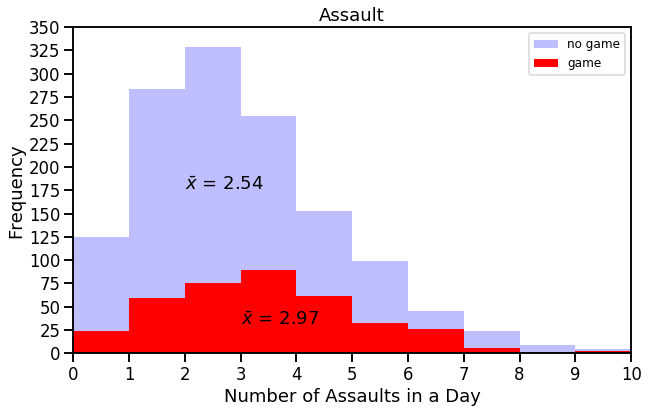

In [10]:
plt.figure(figsize=(10,6))
sns.set_context('talk')
plt.hist(assault_counts_nogame, stacked=True, bins=range(0,11), alpha=0.25, color='b', label='no game')
plt.hist(assault_counts_game, stacked=True, bins=range(0,11), color='r', label='game')
plt.xlabel('Number of Assaults in a Day')
plt.ylabel('Frequency')
plt.title('Assault')
plt.ylim(0, 350)
plt.xlim(0, 10)
plt.xticks(ticks=range(0,11))
plt.yticks(ticks=range(0,351,25))
plt.text(2, 175, r'$\bar{x}$ = 2.54')
plt.text(3, 30, r'$\bar{x}$ = 2.97')
plt.legend(prop={'size': 12})

In [0]:
stats.shapiro(assault_counts_game)
stats.shapiro(assault_counts_nogame)

(0.92680424451828, 6.178320152721835e-25)

Based on the kurtosis and skewness of our two groups, as well as the shape of the histogram and a Shapiro-Wilk test, it looks safe to assume each sample approximates normality. Therefore, we proceed with a t-test for independent samples.

In [0]:
stats.ttest_ind(assault_counts_game, assault_counts_nogame)

Ttest_indResult(statistic=4.243404057293897, pvalue=2.31996383789721e-05)

In [0]:
def get_95_ci(array_1, array_2):
    sample_1_n = array_1.shape[0]
    sample_2_n = array_2.shape[0]
    sample_1_mean = array_1.mean()
    sample_2_mean = array_2.mean()
    sample_1_var = array_1.var()
    sample_2_var = array_2.var()
    mean_difference = sample_2_mean - sample_1_mean
    std_err_difference = math.sqrt((sample_1_var/sample_1_n)+(sample_2_var/sample_2_n))
    margin_of_error = 1.96 * std_err_difference
    ci_lower = mean_difference - margin_of_error
    ci_upper = mean_difference + margin_of_error
    return("The difference in means at the 95% confidence interval (two-tail) is between "+str(ci_lower)+" and "+str(ci_upper)+".")

get_95_ci(assault_counts_nogame, assault_counts_game)

'The difference in means at the 95% confidence interval (two-tail) is between 0.23130940545853879 and 0.6366943556175113.'

Text(0.5, 1.0, 'Assault Incidents')

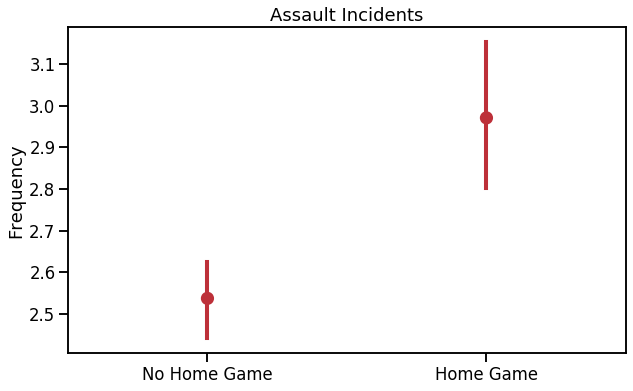

In [0]:
plt.figure(figsize=(10,6))
#sns.set(style="whitegrid")
sns.set_context('talk')
g = sns.pointplot(data=[assault_counts_nogame,
                        assault_counts_game],
                  join=False, color="#bd3039")
                        
g.set(xticklabels = ['No Home Game', 'Home Game'])
g.set(ylabel="Frequency")
g.set_title("Assault Incidents")

Based on our test statistic and p-value (< 0.001) we determine that the difference in the average number of assaults per day between days with and without a Red Sox home game is significant. Additionally, this difference, at the 95% confidence interval is between 0.247 and 0.655 assaults per day. This represents an increase of ~10-25% in the rate of assault in the Fenway area.

Next, we'll run a similar analysis on public indency crimes.

In [0]:
publicindecency_counts_game = publicindecency_counts[publicindecency_counts.index.isin(bos_home_dates)]
publicindecency_counts_nogame = publicindecency_counts[~publicindecency_counts.index.isin(bos_home_dates)]
print(stats.describe(publicindecency_counts_game))
print(stats.describe(publicindecency_counts_nogame))

DescribeResult(nobs=378, minmax=(0, 6), mean=1.066137566137566, variance=1.0857998961447237, skewness=0.98049096579535, kurtosis=1.3081125114898313)
DescribeResult(nobs=1328, minmax=(0, 7), mean=1.0075301204819278, variance=1.133326826522367, skewness=1.3308976175169724, kurtosis=2.6291602304516877)


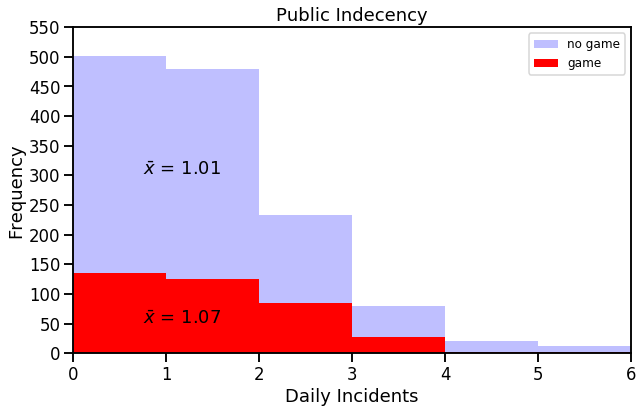

In [0]:
plt.figure(figsize=(10,6))
#sns.set(style="white")
sns.set_context('talk')
plt.hist(publicindecency_counts_nogame, stacked=True, bins=range(0,7), alpha=0.25, color='b', label='no game')
plt.hist(publicindecency_counts_game, stacked=True, bins=range(0,7), color='r', label='game')
plt.xlabel('Daily Incidents')
plt.ylabel('Frequency')
plt.title('Public Indecency')
plt.ylim(0, 550)
plt.xlim(0, 6)
plt.xticks(ticks=range(0,7))
plt.yticks(ticks=range(0,551,50))
plt.text(0.75, 300, r'$\bar{x}$ = 1.01')
plt.text(0.75, 50, r'$\bar{x}$ = 1.07')
plt.legend(prop={'size': 12})

In [0]:
stats.kruskal(publicindecency_counts_game, publicindecency_counts_nogame)

KruskalResult(statistic=1.691906046334335, pvalue=0.19334990079263703)

The samples of public indecency crimes do not approximate a normal distribution. Therefore, we use a Kruskal-Wallis test to check for a significant difference in the means. Based on the results, we cannot reject our null hypothesis. We cannot conclude that Red Sox home games have a significant affect on the rate of public indecency.

In [0]:
vandalism_counts_game = vandalism_counts[vandalism_counts.index.isin(bos_home_dates)]
vandalism_counts_nogame = vandalism_counts[~vandalism_counts.index.isin(bos_home_dates)]
print(stats.describe(vandalism_counts_game))
print(stats.describe(vandalism_counts_nogame))

DescribeResult(nobs=378, minmax=(0, 8), mean=1.5952380952380953, variance=1.9497915877226222, skewness=1.026920548044452, kurtosis=1.276192258206227)
DescribeResult(nobs=1328, minmax=(0, 28), mean=1.4058734939759037, variance=2.2865366893345804, skewness=4.912681851350377, kurtosis=72.36120972669714)


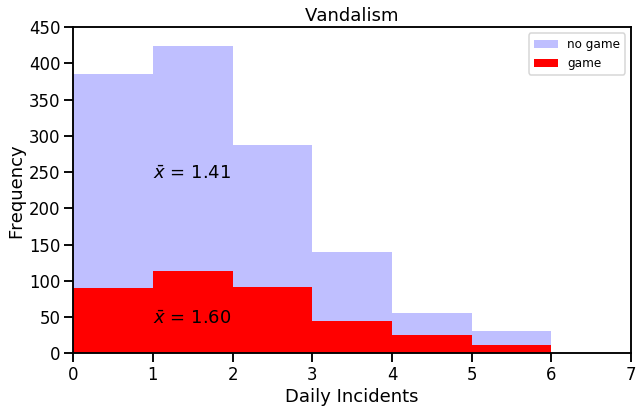

In [0]:
plt.figure(figsize=(10,6))
plt.hist(vandalism_counts_nogame, stacked=True, bins=range(0,7), alpha=0.25, color='b', label='no game')
plt.hist(vandalism_counts_game, stacked=True, bins=range(0,7), color='r', label='game')
plt.xlabel('Daily Incidents')
plt.ylabel('Frequency')
plt.title('Vandalism')
plt.ylim(0, 450)
plt.xlim(0, 7)
plt.xticks(ticks=range(0,8))
plt.yticks(ticks=range(0,451,50))
plt.text(1, 240, r'$\bar{x}$ = 1.41')
plt.text(1, 40, r'$\bar{x}$ = 1.60')
plt.legend(prop={'size': 12})

In [0]:
stats.kruskal(vandalism_counts_game, vandalism_counts_nogame)

KruskalResult(statistic=7.223718860355299, pvalue=0.007194650083418195)

Similar to public indecency, we see that the samples for vandalism incidents are non-normal. However, in this case, our Kruskal-Wallis test determines that we can reject the null hypothesis at the 95% confidence level. The occurrence of a Red Sox home game does appear to have a significant effect on the rate of vandalism in the Fenway area. Since the samples are non normal, however, I have not created a confidence interval for this difference.

In [0]:
stats.mannwhitneyu(vandalism_counts_game, vandalism_counts_nogame)

MannwhitneyuResult(statistic=229034.0, pvalue=0.003597984356481144)